# Barnard's ster

In dit notebook zoeken we de gegevens van Barnard's ster op in de Gaia DR2 catalogus met behulp van wat code in Python waarmee je direct met de database in Madrid kunt communiceren. Een uitgebreide uitleg is [hier](gea.esac.esa.int/archive-help/index.html) te vinden onder het kopje _Python client_.

Het volgende blok Python code zet wat dingen klaar die we later nodig hebben. Om de code te draaien klik je ergens in het blok en toets dan CTRL+Enter in.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astroquery.gaia import Gaia
import astropy.units as u
Av = (u.AU/u.yr).to(u.km/u.s)

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## ADQL query

Nu gebruiken we het [astroquery]() 'Gaia' commando om een ADQL query te maken voor de gegevens van Barnard's Ster zoals dat eerder gedaan is met het web-interface van het Gaia Archive.

In [3]:
job = Gaia.launch_job_async("SELECT source_id,ra,dec,parallax,pmra,pmdec,radial_velocity \
                            FROM gaiadr2.gaia_source  WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec), \
                                                                     CIRCLE('ICRS',269.4486143580427,4.737980765585507,0.001388888888888889))=1", \
                           dump_to_file=False)

barnard_data = job.get_results()

Query finished.


De data worden in een tabel teruggegeven zoals met het "print()" commando te zien is.

In [4]:
print(barnard_data)

     source_id              ra        ...       pmdec        radial_velocity
                           deg        ...      mas / yr           km / s    
------------------- ----------------- ... ------------------ ---------------
4472832130942575872 269.4486143580427 ... 10362.542163273869              --


Met "info" kunnen we meer over de tabel leren. Het gaat nu voornamelijk om de namen van de kolommen.

In [5]:
print(barnard_data.info)

<Table masked=True length=1>
      name       dtype    unit   format                            description                             n_bad
--------------- ------- -------- ------ ------------------------------------------------------------------ -----
      source_id   int64                 Unique source identifier (unique within a particular Data Release)     0
             ra float64      deg {!r:>}                                                    Right ascension     0
            dec float64      deg {!r:>}                                                        Declination     0
       parallax float64      mas {!r:>}                                                           Parallax     0
           pmra float64 mas / yr {!r:>}                         Proper motion in right ascension direction     0
          pmdec float64 mas / yr {!r:>}                             Proper motion in declination direction     0
radial_velocity float64   km / s {!r:>}                            

We kunnen de individuele gegevens ($\alpha$, $\delta$, $\varpi$, $\mu_{\alpha,*}$, $\mu_\delta$) al volgt uit de tabel halen, waarbij we de hemel coordinaten omzetten naar radialen.

In [6]:
ra = barnard_data['ra'][0]*np.pi/180.0
dec = barnard_data['dec'][0]*np.pi/180.0
parallax = barnard_data['parallax'][0]
pmra = barnard_data['pmra'][0]
pmdec = barnard_data['pmdec'][0]

De radi&euml;le snelheid van Barnard's ster is (nog) niet gemeten door Gaia maar is bekend uit andere bronnen, bijvoorbeeld de [Simbad](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=barnard%27s+star&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) database.

In [7]:
vrad = -110.51

## 3D positie en snelheid

We kunnen nu de formules gebruiken uit het [notebook](./GaiaData.ipynb) over Gaia data om de 3D positie en snelheid van de ster te berekenen.

In [8]:
b = 1000/parallax
x = np.cos(ra)*np.cos(dec)*b
y = np.sin(ra)*np.cos(dec)*b
z = np.sin(dec)*b

print("afstand = {0:6.3f} pc".format(b))
print("      X = {0:6.3f} pc".format(x))
print("      y = {0:6.3f} pc".format(y))
print("      z = {0:6.3f} pc".format(z))

afstand =  1.827 pc
      X = -0.018 pc
      y = -1.820 pc
      z =  0.151 pc


In [9]:
vx = -np.sin(ra)*pmra*Av/parallax - np.sin(dec)*np.cos(ra)*pmdec*Av/parallax + np.cos(ra)*np.cos(dec)*vrad
vy =  np.cos(ra)*pmra*Av/parallax - np.sin(dec)*np.sin(ra)*pmdec*Av/parallax + np.sin(ra)*np.cos(dec)*vrad
vz =                                           np.cos(dec)*pmdec*Av/parallax +            np.sin(dec)*vrad

print("vx = {0:7.3f} km/s".format(vx))
print("vy = {0:7.3f} km/s".format(vy))
print("vz = {0:7.3f} km/s".format(vz))
print("vtot = {0:7.3f} km/s".format(np.sqrt(vx*vx+vy*vy+vz*vz)))

vx =  -5.820 km/s
vy = 117.606 km/s
vz =  80.296 km/s
vtot = 142.522 km/s


De berekening kan in Python ook uitgevoerd worden in termen van de vectoren $\mathbf{p}$, $\mathbf{q}$ en $\mathbf{r}$.

In [10]:
p = np.array([-np.sin(ra), np.cos(ra), 0])
q = np.array([-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)])
r = np.array([np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)])

(x, y, z) = r*b
(vx, vy, vz) = p*pmra*Av/parallax + q*pmdec*Av/parallax + r*vrad

print(" X = {0:6.3f} pc".format(x))
print(" y = {0:6.3f} pc".format(y))
print(" z = {0:6.3f} pc".format(z))
print("vx = {0:7.3f} km/s".format(vx))
print("vy = {0:7.3f} km/s".format(vy))
print("vz = {0:7.3f} km/s".format(vz))

 X = -0.018 pc
 y = -1.820 pc
 z =  0.151 pc
vx =  -5.820 km/s
vy = 117.606 km/s
vz =  80.296 km/s


## 3D plaatje van Barnard's ster ten opzichte van de zon

Tot slot gebruiken we het graphisch pakket [matplotlib](https://matplotlib.org) om een 3D plaatje te maken van de positie van Barnard's ster ten opzichte van de zon en we laten ook de snelheidsvector zien. De zon zit in de oorpsrong van het coordinatensysteem.

Vier verschillende projecties worden gebruikt om goed inzicht te geven in hoe Barnard's ster beweegt ten opzichte van de zon. Uit de negatieve waar van de snelheid volgt dat de ster op de zon afkomt en de grote postieve eigenbeweging in declinatie impliceert een grote snelheid in de richting van de positieve $z$-as. Beide effecten zijn goed te zien in de plaatjes.

__NB:__ Bij het maken van deze 3D plaatjes met vectoren erin is het belangrijk om hetzelfde bereik aan elke as toe te kennen omdat ander matplolib de vectoren met verschillende factoren schaalt ten opzichte van de 3 assen.

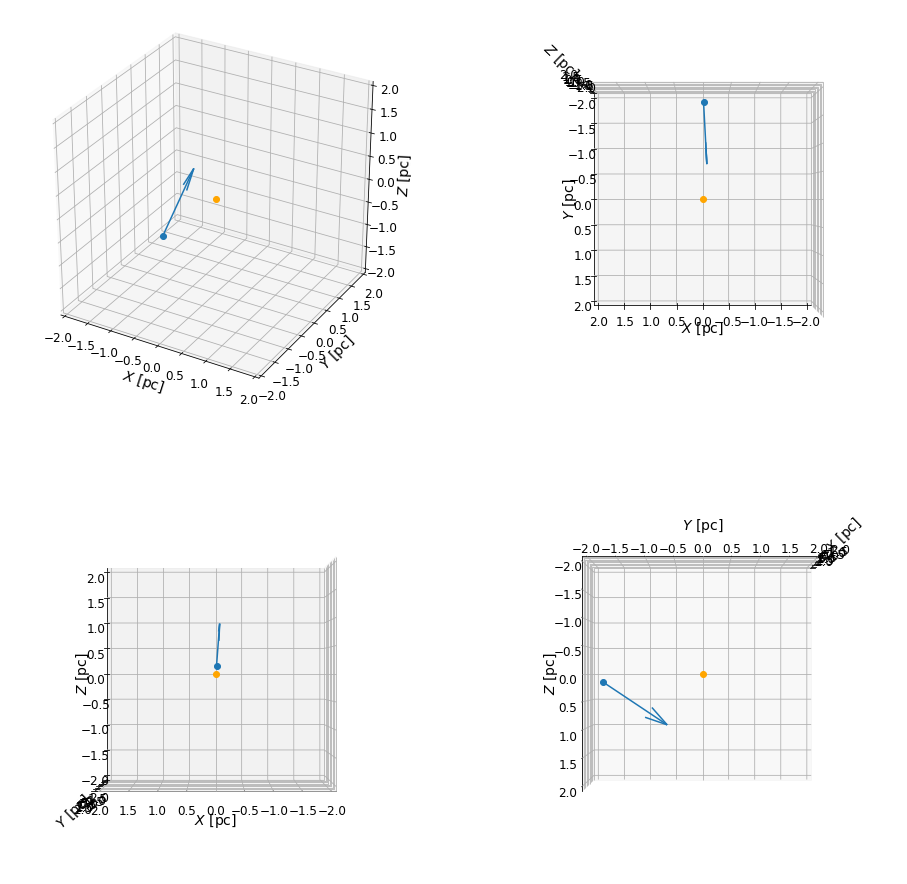

In [11]:
fig = plt.figure(figsize=(8*2,8*2))
axA = fig.add_subplot(2, 2, 1, projection='3d')
axA.view_init(None, None)
axB = fig.add_subplot(2, 2, 2, projection='3d')
axB.view_init(90, 90)
axC = fig.add_subplot(2, 2, 3, projection='3d')
axC.view_init(0, 90)
axD = fig.add_subplot(2, 2, 4, projection='3d')
axD.view_init(180, 0)

for ax in [axA, axB, axC, axD]:
    ax.plot([0], [0], [0], 'o', color='orange')
    ax.plot([x], [y], [z], 'o')
    ax.quiver(x, y, z, vx, vy, vz, length=0.01, normalize=False)
    ax.set_xlabel(r'$X$ [pc]', fontsize=14)
    ax.set_ylabel(r'$Y$ [pc]', fontsize=14)
    ax.set_zlabel(r'$Z$ [pc]', fontsize=14)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(-2,2)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="z", labelsize=12)

plt.show()